In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/videogamesales/vgsales.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Чтение df, проверка типов данных

In [3]:
df = pd.read_csv('/kaggle/input/videogamesales/vgsales.csv')
df.head()


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


# Описание колонок

1. Rank - Рейтинг общих продаж, integer
2. Name - Название игры, object
3. Platform - Платформа выпуска игры, object
4. Year - Год выпуска игры, float
5. Genre - Жанр игры, object
6. Publisher - Издатель игры, object
7. NA_Sales - Продажи в Северной Америке (в миллионах), float
8. EU_Sales - Продажи в Европе (в миллионах), float
9. JP_Sales - Продажи в Японии (в миллионах), float
10. Other_Sales - Продажи в остальном мире (в миллионах), float
11. Global_Sales - Общие мировые продажи, float

# Убираем пропуски в данных

In [4]:
df.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

Были обнаружены пропуски: 271 пропущенное значение в колонке Year, 58 пропущенных значений в колонке Publisher.
Так как колонка Year является числовой и представляет собой важную информацию, удаление строк с пропусками могло бы привести к потере значительной части информации, поэтому было принято решение заполнить пропуски медианным значением по колонке.

In [4]:
df['Year'] = df['Year'].fillna(df['Year'].median())

Так как Publisher является категориальной переменной (строковые значения), а удаление строк снова привело бы к потере данных, было принято решение заполнить пропуски значением Unknown.

In [5]:
df['Publisher'] = df['Publisher'].fillna('Unknown')

# Анализ данных для построения модели

### Анализ целевой переменной Global_Sales

Целевая переменная Global_Sales представляет собой суммарные мировые продажи видеоигр (в миллионах копий).  
Посмотрим её распределение, чтобы понять, насколько данные сбалансированы, есть ли выбросы, а также какой общий уровень продаж.

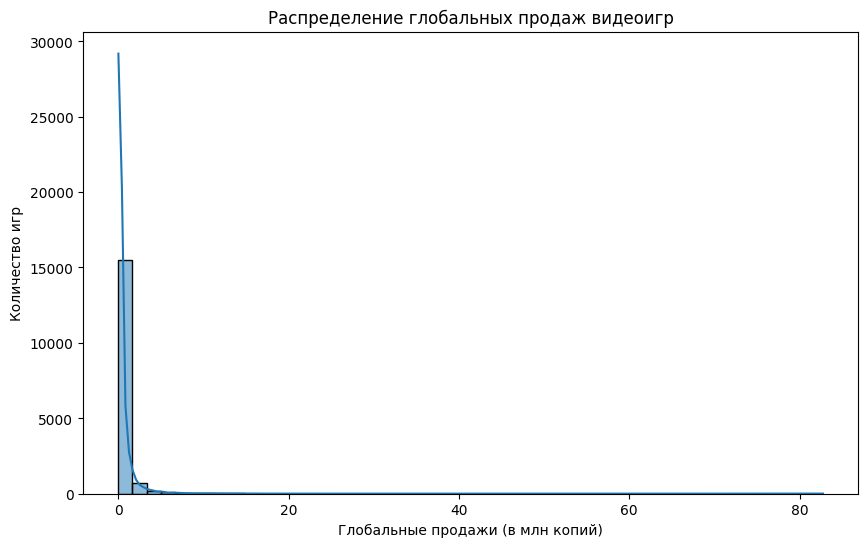

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
plt.figure(figsize=(10, 6))
sns.histplot(df['Global_Sales'], bins=50, kde=True)
plt.title('Распределение глобальных продаж видеоигр')
plt.xlabel('Глобальные продажи (в млн копий)')
plt.ylabel('Количество игр')
plt.show()

Гистограмма с KDE, показывающая форму распределения.

Построим  Boxplot, чтобы увидеть выбросы

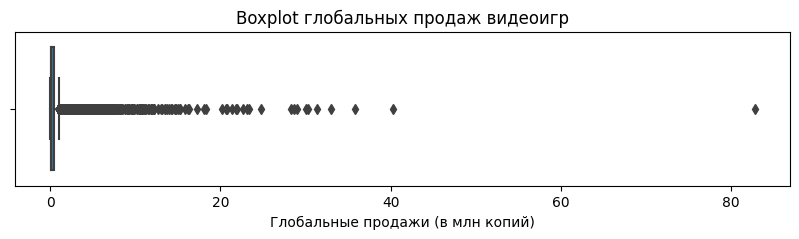

In [17]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['Global_Sales'])
plt.title('Boxplot глобальных продаж видеоигр')
plt.xlabel('Глобальные продажи (в млн копий)')
plt.show()

- Распределение Global_Sales сильно скошено вправо: большинство игр продаются в пределах 0–1 миллиона копий
- Имеются явные выбросы — игры с продажами выше 10, 20 и даже 80 млн копий (например, GTA V, Wii Sports)
- Выбросы можно либо оставить, либо отдельно рассмотреть на этапе подготовки данных для модели.

### Распределение количества игр по платформам

Рассмотрим, на каких платформах выходило наибольшее количество видеоигр.

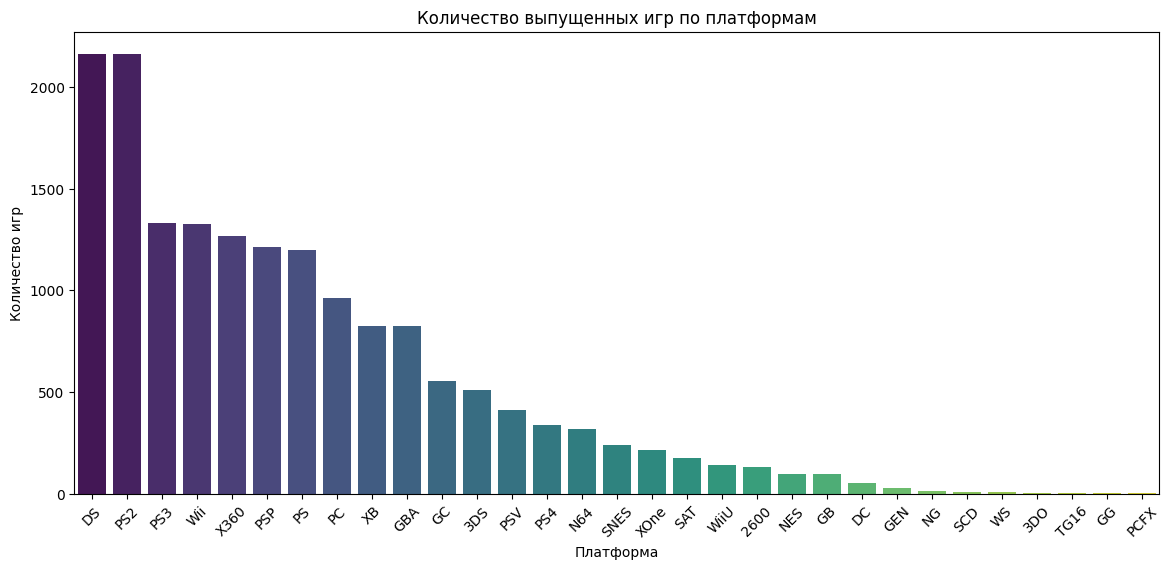

In [18]:
plt.figure(figsize=(14, 6))
platform_counts = df['Platform'].value_counts().sort_values(ascending=False)
sns.barplot(x=platform_counts.index, y=platform_counts.values, palette='viridis')
plt.title('Количество выпущенных игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество игр')
plt.xticks(rotation=45)
plt.show()

Платформы DS, PS2, PS3 и Wii лидируют по количеству выпущенных игр. 

### Распределение количества игр по жанрам

Посмотрим, какие жанры видеоигр были наиболее популярны по количеству релизов.

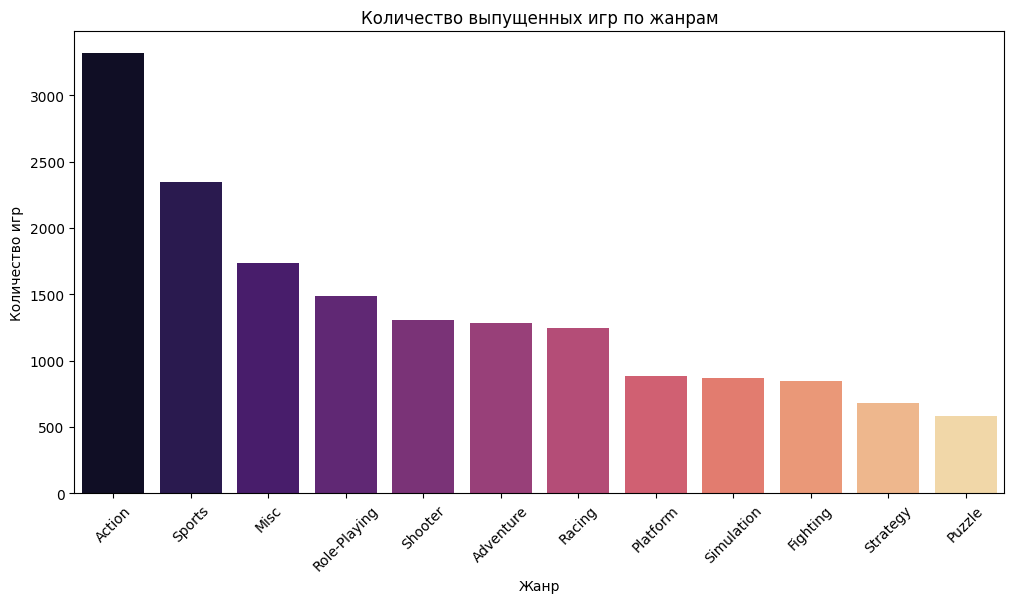

In [19]:
plt.figure(figsize=(12, 6))
genre_counts = df['Genre'].value_counts()
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='magma')
plt.title('Количество выпущенных игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество игр')
plt.xticks(rotation=45)
plt.show()

Чаще всего выходили игры жанров Action, Sports и Misc. Реже всего — Strategy и Puzzle.

### Глобальные продажи по платформам

Теперь посмотрим, как глобальные продажи различаются между платформами.

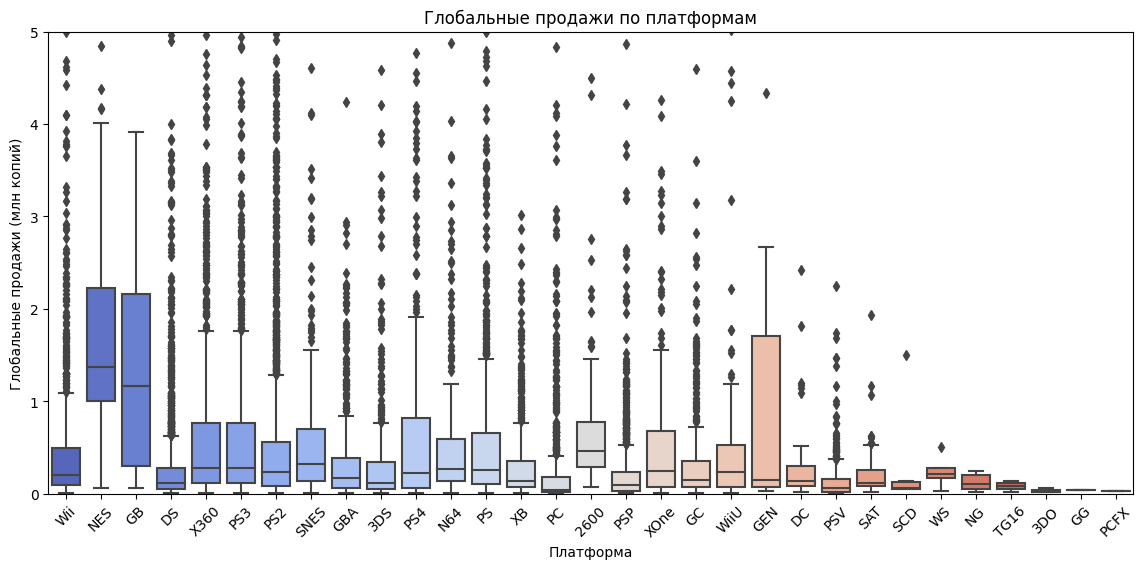

In [20]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Platform', y='Global_Sales', data=df, palette='coolwarm')
plt.title('Глобальные продажи по платформам')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн копий)')
plt.xticks(rotation=45)
plt.ylim(0, 5)  
plt.show()

Наибольшие продажи в среднем наблюдаются у платформ Wii, PS2, NES. Некоторые платформы, такие как GB и 2600, показывают низкие медианные значения.

### Глобальные продажи по жанрам

Посмотрим, как глобальные продажи зависят от жанра игры.

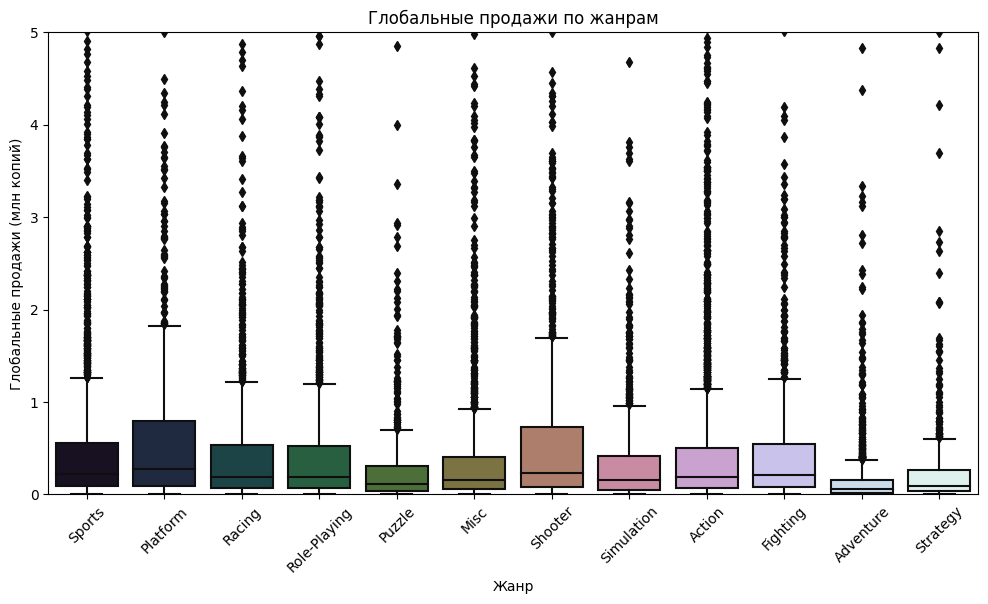

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Global_Sales', data=df, palette='cubehelix')
plt.title('Глобальные продажи по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Глобальные продажи (млн копий)')
plt.xticks(rotation=45)
plt.ylim(0, 5) 
plt.show()

Жанры Platform, Shooter, Racing, Role-Playing показывают более высокие медианные значения продаж. Игры жанра Puzzle и Strategy в среднем продаются хуже.

### Топ-10 издателей по количеству игр
Так как колонка Publisher содержит слишком много уникальных значений, barplot по ней может быть плохочитабельным, поэтому можно построить график топ-10 издателей по количеству игр.

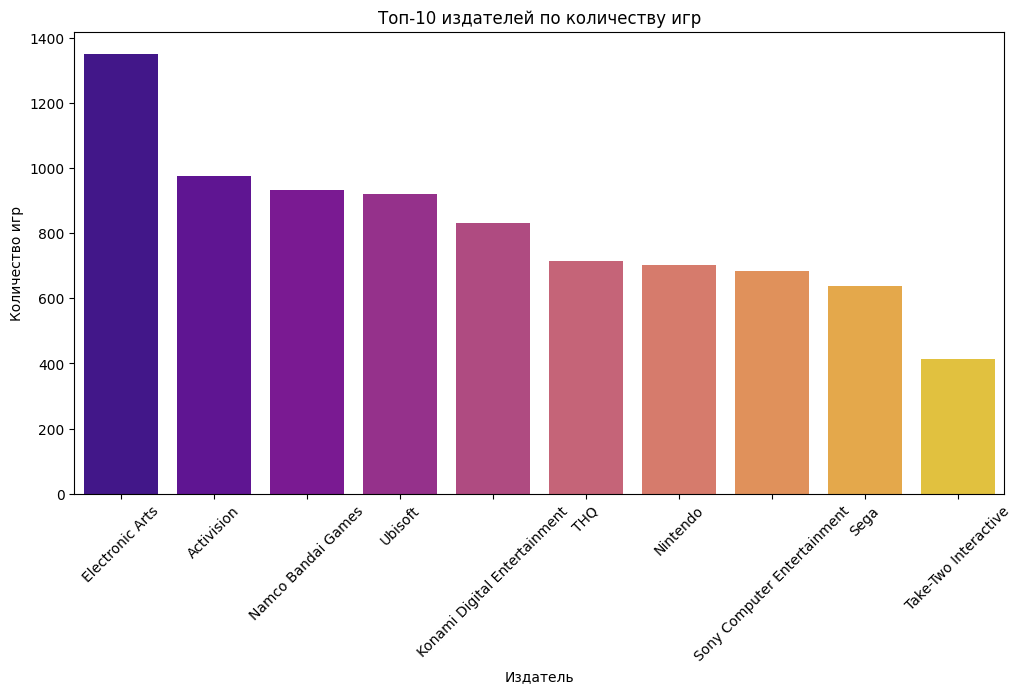

In [22]:
plt.figure(figsize=(12, 6))
top_publishers = df['Publisher'].value_counts().nlargest(10)
sns.barplot(x=top_publishers.index, y=top_publishers.values, palette='plasma')
plt.title('Топ-10 издателей по количеству игр')
plt.xlabel('Издатель')
plt.ylabel('Количество игр')
plt.xticks(rotation=45)
plt.show()

### Вывод по анализу категориальных признаков

Платформы: Наибольшее количество игр было выпущено для DS, PS2, PS3 и Wii, что говорит о высокой популярности этих платформ в определённые периоды. Однако по уровню глобальных продаж (медиане) лидируют Wii, PS2 и NES, что может указывать на более успешные релизы на этих платформах.

Жанры: Жанры Action, Sports и Misc — самые массовые по числу игр. Тем не менее, по продажам выделяются жанры Shooter, Platform и Racing, которые, хоть и не всегда многочисленны, демонстрируют высокую коммерческую эффективность.

Издатели: Среди топ-издателей по количеству игр — такие, как Electronic Arts, Activision и Namco Bandai. Их доля в индустрии значительна, что подтверждает их влияние на рынок.

Эти наблюдения важны для понимания того, какие комбинации платформ и жанров наиболее перспективны с точки зрения продаж, также может быть полезным для прогнозирования успеха будущих игр, особенно при дальнейшем анализе зависимости признаков от таргета.

### Анализ числового признака Year

Анализируем, как менялись продажи видеоигр по годам, что поможет определить ключевые временные периоды в индустрии и понять, в какие годы рынок был особенно активен.

### Сколько игр выходило в разные годы 

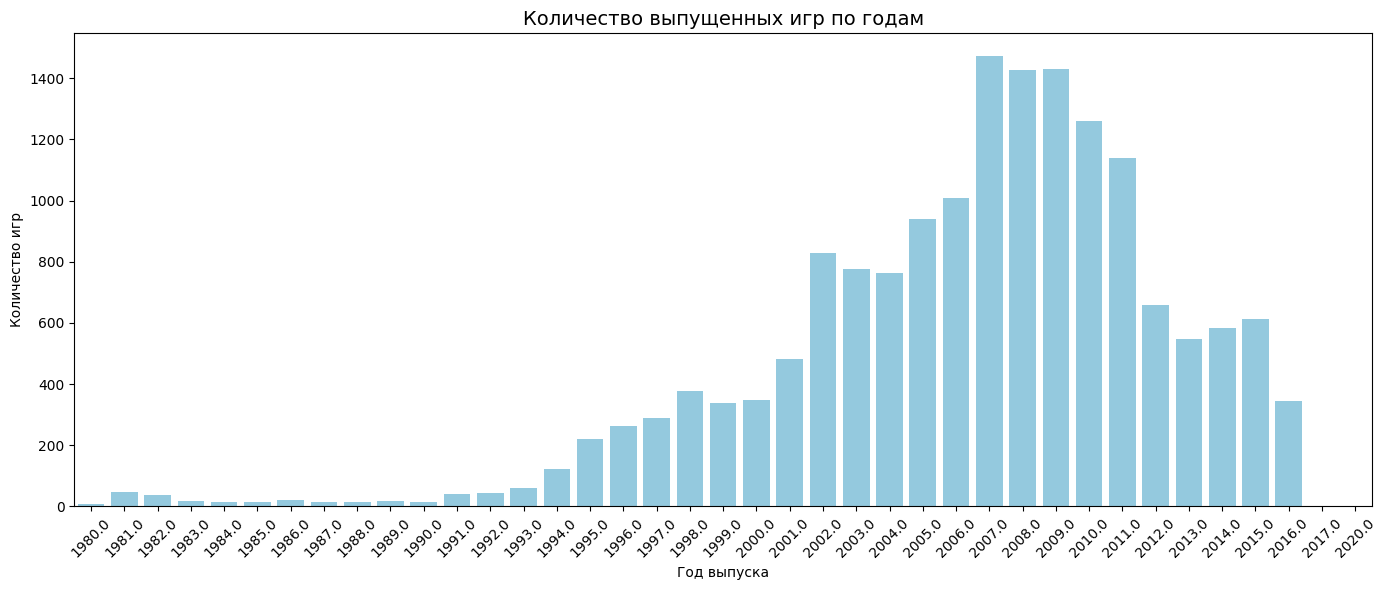

In [23]:
games_per_year = df['Year'].value_counts().sort_index()
plt.figure(figsize=(14, 6))
sns.barplot(x=games_per_year.index, y=games_per_year.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('Количество выпущенных игр по годам', fontsize=14)
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.tight_layout()
plt.show()

На графике видно, что количество выпускаемых игр росло с начала 2000-х и достигло пика в период 2007–2009 годов. Это совпадает с расцветом таких платформ, как Xbox 360, PlayStation 3 и Nintendo Wii. После 2010 года наблюдается заметный спад релизов, вероятно, связанный с переходом к цифровой дистрибуции, снижением интереса к физическим копиям игр или изменением моделей потребления (например, рост мобильных игр).

### Как менялись продажи по годам

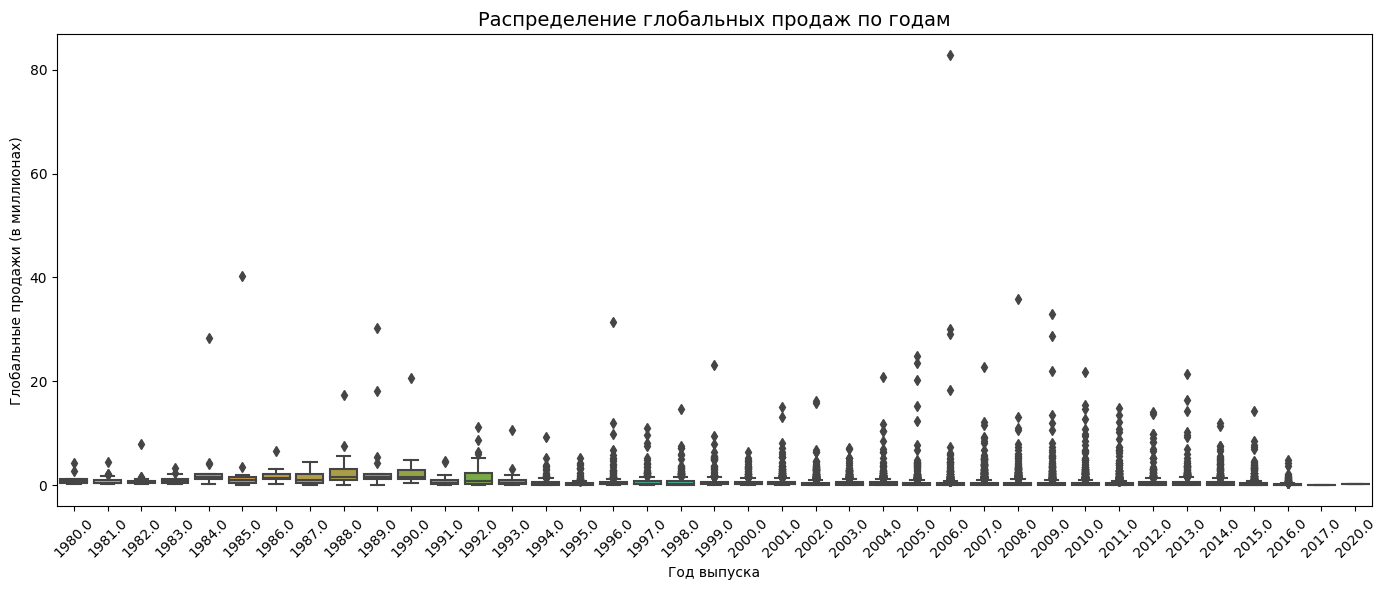

In [24]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Year', y='Global_Sales', data=df)
plt.xticks(rotation=45)
plt.title('Распределение глобальных продаж по годам', fontsize=14)
plt.xlabel('Год выпуска')
plt.ylabel('Глобальные продажи (в миллионах)')
plt.tight_layout()
plt.show()

Boxplot показывает, что медианные значения глобальных продаж со временем снижаются. Несмотря на рост количества игр в период 2005–2010, типичная игра продавалась всё хуже — возможно, из-за насыщения рынка. Также наблюдаются выбросы — отдельные игры, которые продавались значительно лучше других. После 2012 года продажи не только снизились, но и стали менее разнообразными, без ярко выраженных «хитов».

### Вывод по анализу числового признака Year

Наибольшее количество игр выходило в период 2006–2011 годов, что может быть связано с активным развитием платформ PS2, Xbox 360 и Wii.

Несмотря на рост количества игр в эти годы, медианные продажи по boxplot'у постепенно снижались, что может говорить о насыщении рынка.

После 2012 года наблюдается падение как количества релизов, так и продаж, вероятно, из-за перехода к цифровой дистрибуции и появления новых моделей распространения игр.

В целом, пик активности и интереса к розничным видеоиграм пришёлся примерно на 2007–2010 годы.

## Анализ исключённых признаков и обоснование их невключения в модель

### Name (название игры)

In [8]:
print("Уникальных названий игр:", df['Name'].nunique())
df['Name'].sample(5)

Уникальных названий игр: 11493


13802      Thoroughbred Breeder II Plus
6678     Ultimate Fighting Championship
8506                    Lethal Skies II
16397            Heart no Kuni no Alice
5903                       Eternal Ring
Name: Name, dtype: object

Name — это уникальное название каждой игры, оно не несёт значимой информации для прогнозирования, не имеет повторяющихся значений так как каждое имя уникально, поэтому не может быть признаком. Если закодировать названия как категорию, то получается модель просто будет запоминать, а не учиться, и это приведёт к переобучению. Поэтому не используется в модели, только для визуализаций или подписей.

### Publisher

#### Распределение количества игр по издателям:

Уникальных издателей: 578


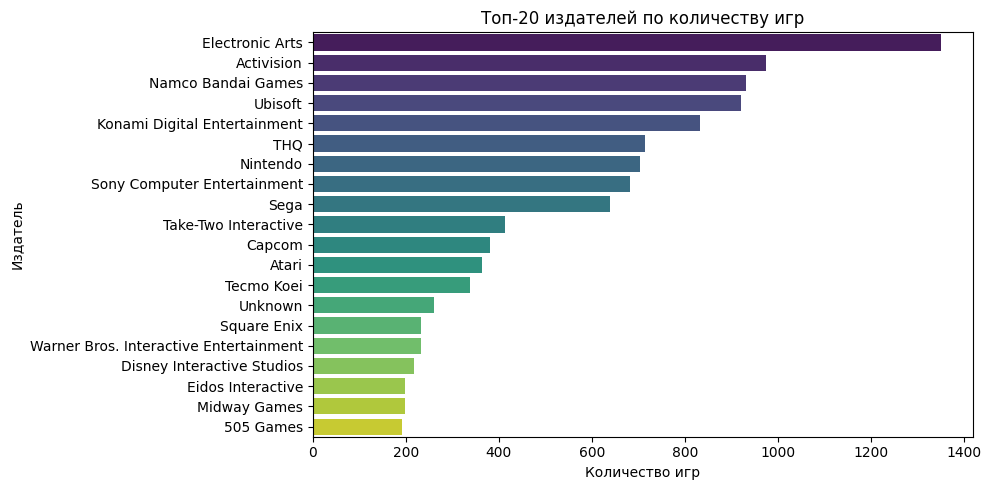

In [9]:
print("Уникальных издателей:", df['Publisher'].nunique())
top_publishers = df['Publisher'].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(y=top_publishers.index, x=top_publishers.values, palette="viridis")
plt.title('Топ-20 издателей по количеству игр')
plt.xlabel('Количество игр')
plt.ylabel('Издатель')
plt.tight_layout()
plt.show()

#### Средние продажи по издателям (топ-10):

In [10]:
top_10 = df.groupby('Publisher')['Global_Sales'].mean().sort_values(ascending=False).head(10)
top_10

Publisher
Palcom                                4.170000
Red Orb                               2.620000
Nintendo                              2.541337
Arena Entertainment                   2.360000
UEP Systems                           2.250000
RedOctane                             2.170000
Valve                                 1.740000
Hello Games                           1.600000
Sony Computer Entertainment Europe    1.592667
Westwood Studios                      1.550000
Name: Global_Sales, dtype: float64

Publisher влияет на маркетинг, качество и успех игры, конечно логично, что крупные издатели могут повышать продажи. Но более 500 уникальных значений, среди них есть дубликаты, опечатки, малозначимые значения. Чтобы использовать Publisher нужно очищать, объединять, группировать по топ-издателям, иначе возникнет переобучение и рост сложности модели. При использовании как категориального признака получается слишком много one-hot столбцов, в таком случае модель станет тяжёлой. Получается можно использовать, но только после предобработки (если оставить только топ-издателей и заменить остальные на "Other"). В моем случае я не включаю для упрощения и фокусировки на основных признаках.

### NA_Sales, EU_Sales, JP_Sales, Other_Sales

#### Распределение по регионам:

In [11]:
df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].mean()

NA_Sales       0.264667
EU_Sales       0.146652
JP_Sales       0.077782
Other_Sales    0.048063
dtype: float64

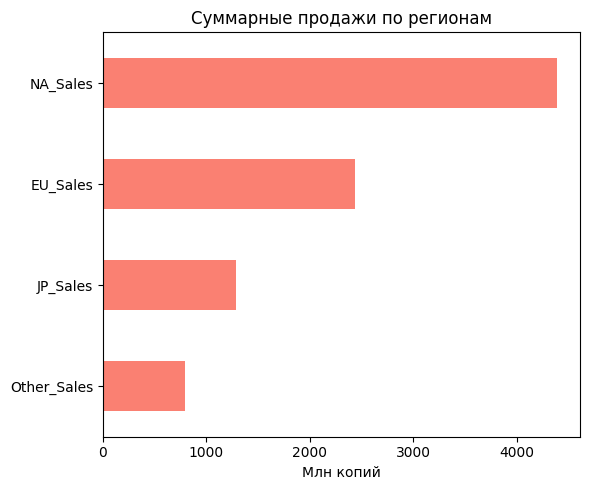

In [12]:
region_totals = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
plt.figure(figsize=(6,5))
region_totals.sort_values().plot(kind='barh', color='salmon')
plt.title("Суммарные продажи по регионам")
plt.xlabel("Млн копий")
plt.tight_layout()
plt.show()

Эти столбцы влияют на Global_Sales, потому что являются её составными частями: Global_Sales = NA_Sales + EU_Sales + JP_Sales + Other_Sales/ Использовать эти признаки при обучении модели на Global_Sales получается нарушением логики, модель будет просто складывать их, а не предсказывать.
Поэтому мы исключаем их модели, так как они напрямую формируют целевую переменную.



Чтобы построить корректную модель прогноза глобальных продаж (`Global_Sales`), я провела исследование и исключила следующие признаки:
#### Name — уникальное название игры
Не несёт статистической ценности, не повторяется, не может быть категориальным признаком.
#### Publisher — издатель игры
Более 500 уникальных значений, требует сложной очистки, возможен переобучение модели, не включён для упрощения.
#### Региональные продажи (NA_Sales, EU_Sales, JP_Sales, Other_Sales)
Являются частями Global_Sales, приведут к утечке данных (data leakage), исключены из модели.
Поэтому, я сфокусировалась на признаках, которые  можно использовать для предсказания: Platform, Genre, Year.

#  Исследование взаимосвязи между признаками и целевой переменной Global_Sales

### Корреляция числовых признаков 

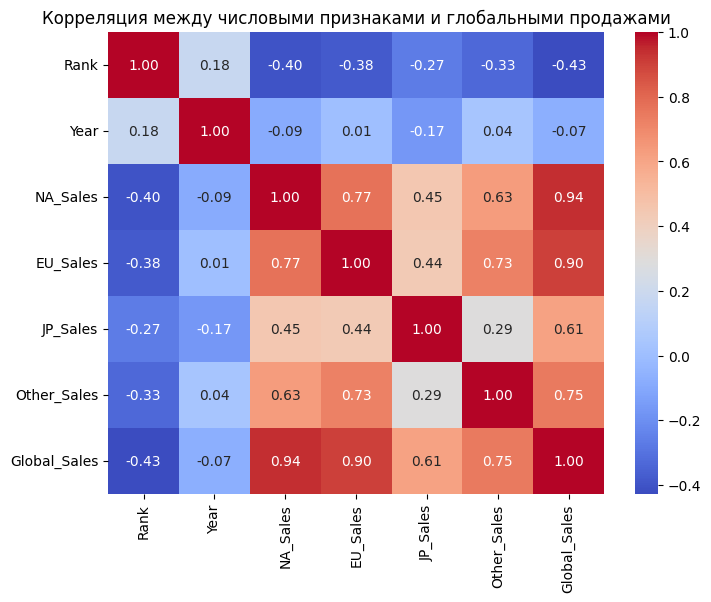

In [25]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция между числовыми признаками и глобальными продажами')
plt.show()

Из числовых признаков наибольшую корреляцию с Global_Sales демонстрируют: NA_Sales, EU_Sales, JP_Sales, Other_Sales — это ожидаемо, так как они входят в сумму Global_Sales. Year имеет слабую или почти нулевую корреляцию с глобальными продажами, что указывает на отсутствие прямой зависимости (возможно, она не линейная или влияет опосредованно).

### Влияние категориальных признаков 

#### Boxplot: Platform vs Global_Sales

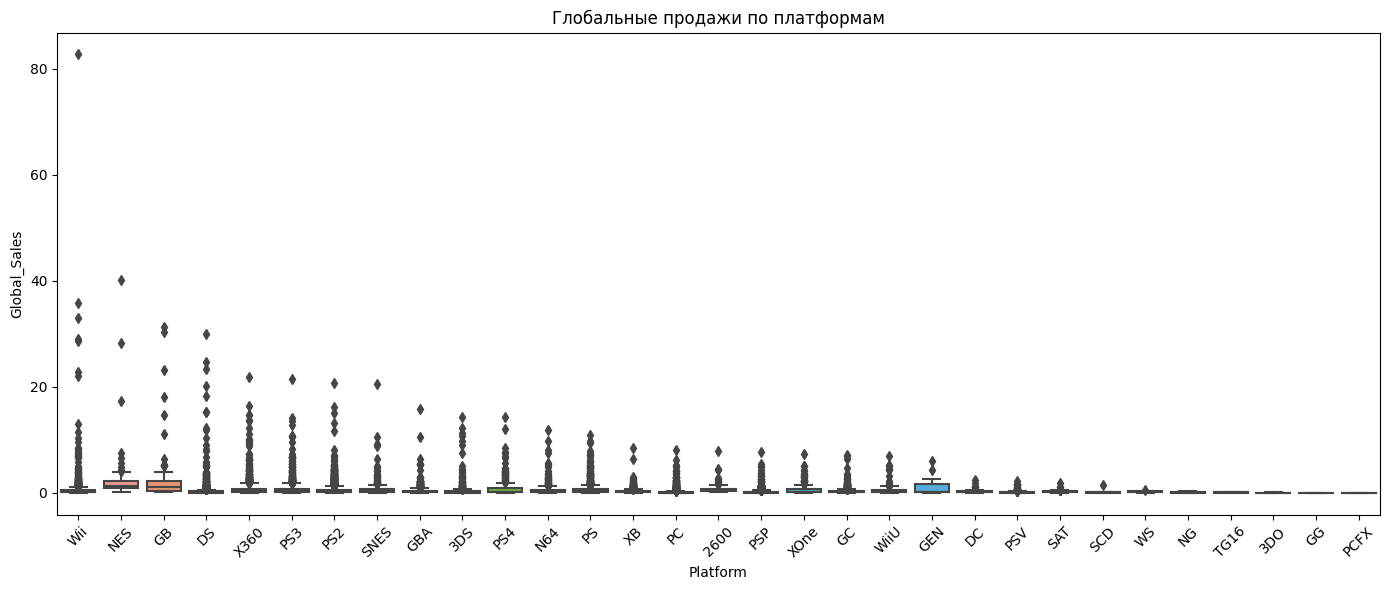

In [26]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Platform', y='Global_Sales', data=df)
plt.title('Глобальные продажи по платформам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Boxplot: Genre vs Global_Sales

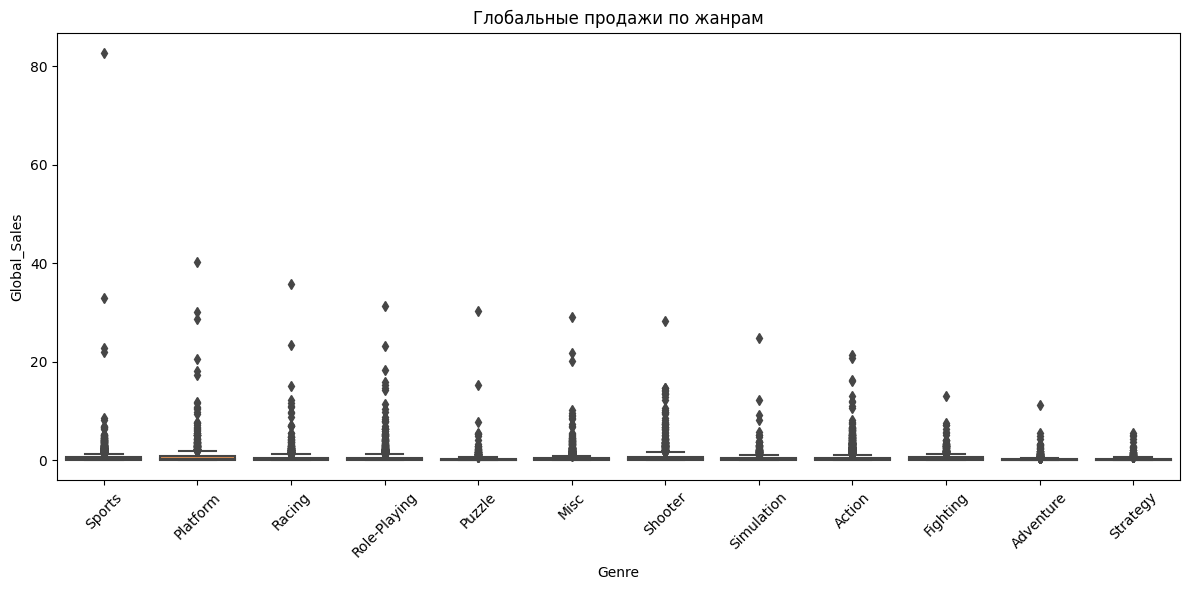

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Global_Sales', data=df)
plt.title('Глобальные продажи по жанрам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
df.groupby('Genre')['Global_Sales'].mean().sort_values(ascending=False)

Genre
Platform        0.938341
Shooter         0.791885
Role-Playing    0.623233
Racing          0.586101
Sports          0.567319
Fighting        0.529375
Action          0.528100
Misc            0.465762
Simulation      0.452364
Puzzle          0.420876
Strategy        0.257151
Adventure       0.185879
Name: Global_Sales, dtype: float64

Платформы Wii, NES, PS2 в среднем демонстрируют более высокие продажи, чем остальные. Жанры Shooter, Platform и Racing также показывают хорошие результаты по средней и медианной продаже. Это говорит о том, что категориальные признаки влияют на продажи, и их обязательно нужно учесть в модели.

### Вывод по корреляционному анализу

Из числовых признаков с Global_Sales логично коррелируют региональные продажи (NA_Sales, EU_Sales и т.д.) — это части глобальных продаж. Год выпуска (Year) не показывает линейной зависимости с продажами, но может влиять в сочетании с другими признаками (например, платформа + год). Категориальные признаки (жанр, платформа) влияют на продажи: определённые жанры и платформы ассоциированы с более высокими глобальными продажами. Это значит, что при построении модели нужно обязательно включить категориальные признаки, но сначала преобразовать их в числовой формат (One-Hot Encoding или Label Encoding).

## Создание новых признаков

In [6]:
from datetime import datetime
df['Age'] = 2025 - df['Year']

Age(возраст игры), прямая числовая замена Year. Логика: чем старее игра, тем вероятнее она продаётся меньше так как устарела, потеряла актуальность. Это помогает выявить временной спад продаж.

In [7]:
top_platforms = df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False).head(5).index.tolist()
df['is_mainstream_platform'] = df['Platform'].apply(lambda x: 1 if x in top_platforms else 0)

is_mainstream_platform отражает, выпущена ли игра на одной из 5 самых продаваемых платформ. Такие платформы, как правило, имеют широкую аудиторию, а значит игра могла получить больше продаж.

In [8]:
top_genres = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False).head(3).index.tolist()
df['is_popular_genre'] = df['Genre'].apply(lambda x: 1 if x in top_genres else 0)

is_popular_genre проверяет, относится ли игра к жанру из топ-3 по продажам. Некоторые жанры традиционно лучше продаются (например, экшены, спорт и шутеры).

In [9]:
aaa_publishers = ['Electronic Arts', 'Nintendo', 'Activision']
df['is_AAA_publisher'] = df['Publisher'].apply(lambda x: 1 if x in aaa_publishers else 0)

Учитываем, что топ-издатели (EA, Nintendo, Activision) обладают большим маркетинговым бюджетом, их игры, как правило, продаются лучше.

## Корреляция новых признаков с Global_Sales

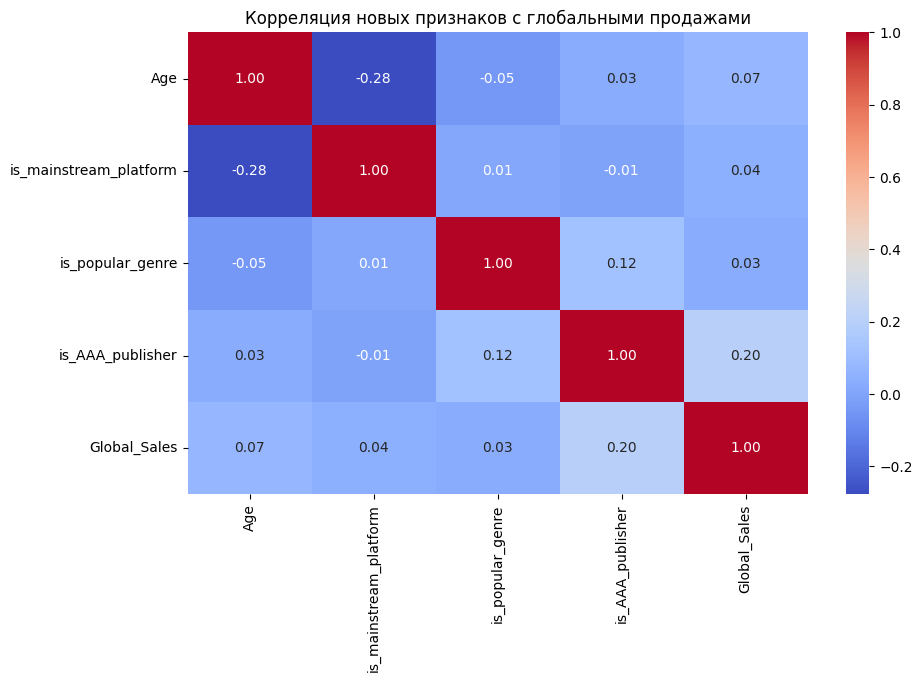

In [16]:
new_features = ['Age', 'is_mainstream_platform', 'is_popular_genre', 'is_AAA_publisher', 'Global_Sales']
plt.figure(figsize=(10, 6))
sns.heatmap(df[new_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляция новых признаков с глобальными продажами")
plt.show()

Age (0.07) очень слабая положительная связь, вероятно, влияние возраста минимально, или оно нивелируется другими факторами (возможно, старые игры переиздаются, что искажает тренд)
is_mainstream_platform (0.04) тоже слабая связь, но можно объяснить тем, что не все хиты выходят только на популярных платформах, а продажи есть и у нишевых платформ
is_popular_genre (0.03) практически не влияет напрямую, но может сочетаться с другими признаками (например, платформой или годом)
is_AAA_publisher (0.20) наиболее сильная связь среди всех новых фичей, это логично: крупные издатели вкладываются в маркетинг, у них больше ресурсов, франшизы и узнаваемость
Новая фича is_AAA_publisher действительно оказалась полезна, можно ожидать, что она будет полезной и при построении модели. Остальные признаки сами по себе не сильно коррелируют с таргетом, но могут усиливать модель в связке с другими. Эти фичи не создают утечки и логически обоснованы, что делает их отличным выбором для будущего машинного обучения.



## Общие выводы о проделанной аналитике

1. В ходе анализа я рассмотрела каждую колонку исходного датасета, чтобы понять, какие признаки целесообразно использовать при построении модели прогноза глобальных продаж видеоигр, а какие лучше исключить. Также были построены визуализации, распределения и рассчитаны базовые статистики.
2. Распределение продаж по платформам сильно варьируется. Платформы PlayStation и DS показали наибольшие суммарные продажи. Визуальный анализ через boxplot показал, что разные платформы имеют разные медианные продажи, признак категориальный, хорошо отражает сегментацию рынка.
3. Жанр влияет на распределение продаж. Например, жанры Action и Sports имеют наибольшие суммарные продажи, Boxplot и barplot помогли визуально оценить медианы и выбросы. Жанр может влиять на предпочтения игроков.
4. Анализ показал, что пик индустрии пришёлся на 2005–2010 годы, построены линейные и категориальные графики по количеству игр и продажам по годам. Год влияет на общий объём продаж и должен учитываться. Также пропуски были заменены на медианное значение.
5. Среди издателей более 500 уникальных значений, средние продажи варьируются, но большая дисперсия мешает использованию как признака без дополнительной обработки, использование в модели без группировки приведёт к переобучению. На данном этапе исключён из модели, но может быть использован позже после группировки.
6. Почти все названия игр уникальны, не несут обобщающей информации для обучения модели.
7. NA_Sales, EU_Sales, JP_Sales, Other_Sales являются составными частями Global_Sales, использование их в модели вызовет data leakage утечку данных.
8. Global_Sales (целевая переменная) имеет распределение с правосторонним скошенным хвостом, очень высокие продажи у немногих игр, распределение нормализовано с помощью логарифмической шкалы на графиках.
9. Было решено использовать только три признака — Platform, Genre и Year, так как они не создают утечку данных, логично связаны с целевой переменной, не требуют глубокой очистки, имеют доказанное влияние на продажи по графикам и статистике.
10. В рамках этапа Feature Engineering были созданы новые признаки: Age — отражает, насколько стара игра (разница между текущим годом и годом выпуска); is_mainstream_platform — бинарный признак, отражающий, входит ли платформа в топ-5 по суммарным продажам; is_popular_genre — бинарный признак, показывающий, входит ли жанр в топ-3 по популярности; is_AAA_publisher — бинарный признак, идентифицирующий издателей из числа топ-3 (EA, Nintendo, Activision).
11. Корреляционный анализ новых признаков показал, что признак is_AAA_publisher имеет наибольшую корреляцию с глобальными продажами (0.20), что подтверждает его значимость. Остальные признаки имеют слабую индивидуальную корреляцию, но потенциально могут быть полезны в составе модели.

## Label Encoding

Прежде чем обучать модель, необходимо разделить признаки на числовые и категориальные. 

In [10]:
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [11]:
numerical_features

['Rank',
 'Year',
 'NA_Sales',
 'EU_Sales',
 'JP_Sales',
 'Other_Sales',
 'Global_Sales',
 'Age',
 'is_mainstream_platform',
 'is_popular_genre',
 'is_AAA_publisher']

In [12]:
categorical_features

['Name', 'Platform', 'Genre', 'Publisher']

Посмотрю, сколько уникальных значений в каждом категориальном признаке, это поможет понять, какие из них можно закодировать через OneHot, а какие стоит закодировать через LabelEncoder.

In [13]:
df[categorical_features].nunique().sort_values(ascending=False)

Name         11493
Publisher      578
Platform        31
Genre           12
dtype: int64

Колонку Name я решила не удалять, так как она не несёт смысловой нагрузки для модели, но может пригодиться на этапе визуализации или анализа, поэтому просто исключу её при обучении. Publisher и Platform закодированы через LabelEncoder, чтобы не раздувать размерность. Genre закодирован через One-Hot, так как категорий немного.

In [14]:
from sklearn.preprocessing import LabelEncoder
df_model = df.copy()
label_encoders = {}
for col in ['Platform', 'Publisher']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le
df_model = pd.get_dummies(df_model, columns=['Genre'], prefix='Genre')

Посмотрим результат

In [11]:
df_model.head()

,Rank,Name,Platform,Year,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,...,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy
0,1,Wii Sports,26,2006.0,359,41.49,29.02,3.77,8.46,82.74,...,False,False,False,False,False,False,False,False,True,False
1,2,Super Mario Bros.,11,1985.0,359,29.08,3.58,6.81,0.77,40.24,...,False,False,True,False,False,False,False,False,False,False
2,3,Mario Kart Wii,26,2008.0,359,15.85,12.88,3.79,3.31,35.82,...,False,False,False,False,True,False,False,False,False,False
3,4,Wii Sports Resort,26,2009.0,359,15.75,11.01,3.28,2.96,33.00,...,False,False,False,False,False,False,False,False,True,False
4,5,Pokemon Red/Pokemon Blue,5,1996.0,359,11.27,8.89,10.22,1.00,31.37,...,False,False,False,False,False,True,False,False,False,False


## Разделение данных

In [12]:
df.shape

(16598, 11)

In [13]:
df

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


In [14]:
X = df_model.drop(columns=['Global_Sales', 'Name', 'Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
y = df_model['Global_Sales']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(f'Размер X_train: {X_train.shape}')
print(f'Размер X_test: {X_test.shape}')
print(f'Размер y_train: {y_train.shape}')
print(f'Размер y_test: {y_test.shape}')

Размер X_train: (13278, 15)
Размер X_test: (3320, 15)
Размер y_train: (13278,)
Размер y_test: (3320,)


Разделила данные на обучающую и тестовую выборки. Обучающая выборка train будет использоваться для построения модели. Тестовая выборка test для оценки качества модели на новых, ранее не виденных данных. Я выбрала соотношение: 80% данных для обучения, 20% для теста. 

## Строим модель

In [40]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

В качестве базовой модели использовано дерево решений (DecisionTreeRegressor), эта модель легко интерпретируема и позволяет оценить важность признаков на начальном этапе.

### Feature Importance

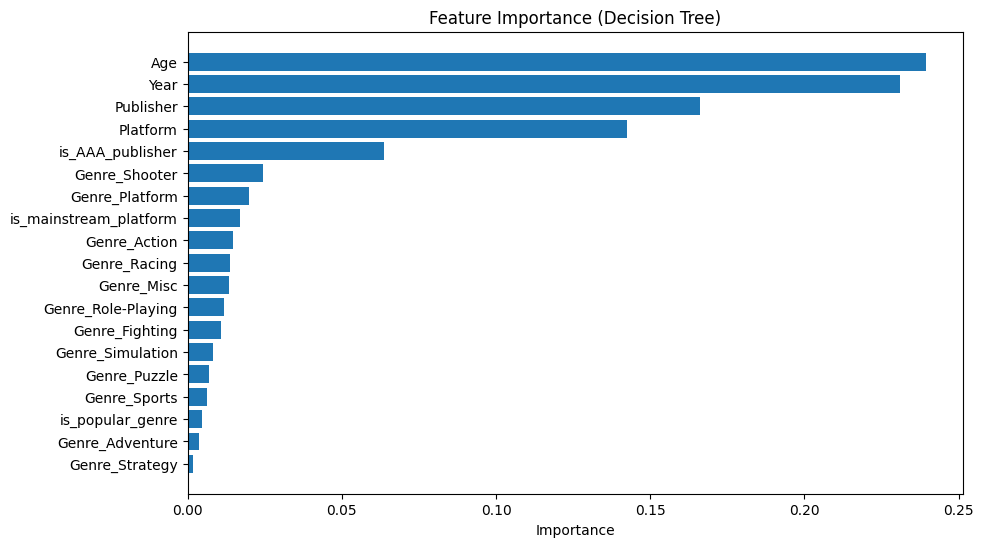

In [41]:
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Decision Tree)')
plt.gca().invert_yaxis()
plt.show()

Feature Importance показывает вклад каждого признака в предсказание модели. Наиболее важные признаки визуализированы на графике. Здесь мы можем оценить эффективность новых созданных фичей и их влияние на модель.

### Оценка метрик модели (MAE, R², NSE, MSRE)

Для оценки качества модели использованы метрики:
- MAE (средняя абсолютная ошибка)
- R² (коэффициент детерминации)
- NSE (эффективность модели по Нэшу–Сатклифу)
- MSRE (среднеквадратичная относительная ошибка)

In [42]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
nse = 1 - sum((y_test - y_pred) ** 2) / sum((y_test - y_test.mean()) ** 2)
msre = (( (y_test - y_pred) / y_test ) ** 2).mean()
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"NSE: {nse:.4f}")
print(f"MSRE: {msre:.4f}")

MAE: 0.6025
R²: -0.1129
NSE: -0.1129
MSRE: 302.2988


Результаты метрик показывают, что модель работает плохо, особенно тревожен отрицательный R² и NSE, получается, что модель работает хуже, чем просто среднее значение.
Попробую поэтапно улучшим модель.

Попробуем удалить выбросы, удалим верхние 5% игр по продажам, так как они являются выбросами и искажают результаты обучения модели.

In [16]:
threshold = df_model['Global_Sales'].quantile(0.95)
df_no_outliers = df_model[df_model['Global_Sales'] <= threshold]

А потом я решила попробовать удалить вообще все возможные выбросы, для этого использовать межквартильный размах (IQR). Выделила только числовые признаки, применила IQR к ним, построила маску выбросов по числовым данным, применила маску ко всему датафрейму.

In [41]:
df_numeric = df_model.select_dtypes(include='number')
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
mask = ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
df_no_outliers = df_model[mask]
print(f"До удаления выбросов: {df_model.shape}")
print(f"После удаления выбросов: {df_no_outliers.shape}")

До удаления выбросов: (16598, 22)
После удаления выбросов: (11926, 22)


Повторно разделим данные

In [43]:
from sklearn.model_selection import train_test_split
X = df_no_outliers.drop(columns=['Global_Sales', 'Name', 'Rank', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
y = df_no_outliers['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Попробуем другую модель — например, Random Forest

In [68]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
msre_xgb = mse_xgb / y_test.var()
nse_xgb = 1 - ((y_test - y_pred_xgb) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
print(f"MAE: {mae_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")
print(f"NSE: {nse_xgb:.4f}")
print(f"MSRE: {msre_xgb:.4f}")

MAE: 0.1063
R²: 0.2593
NSE: 0.2593
MSRE: 0.7404


Для улучшения качества модели была использована Random Forest Regressor, так как она лучше захватывает сложные закономерности в данных. После удаления выбросов модель переобучена и переоценена по всем метрикам.

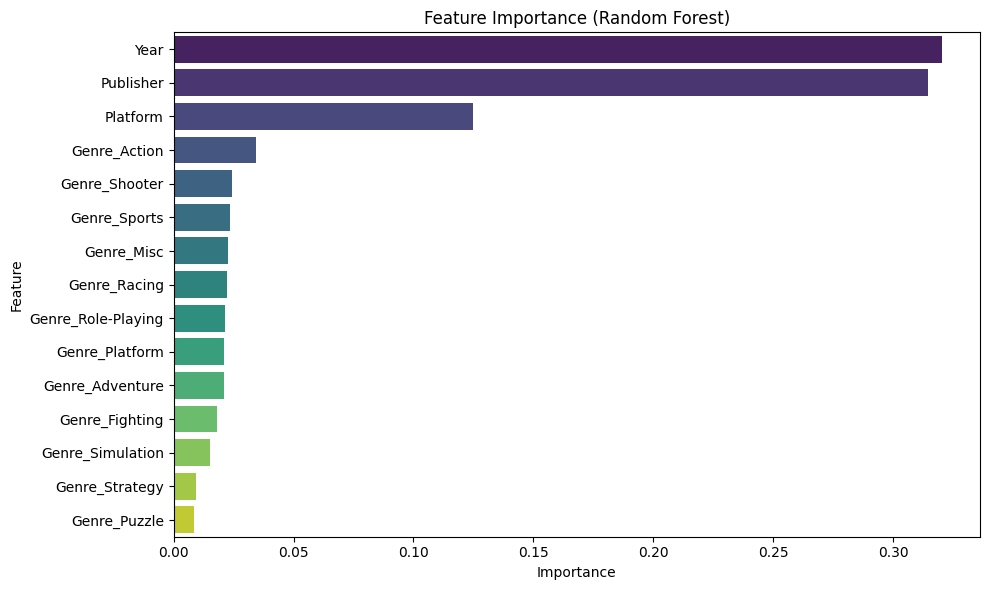

In [20]:
importances = model_rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

Попробуем и дальше поэксперементировать с моделями машинного обучения

##  Линейная регрессия (без кросс-валидации)

Я начинаю эксперименты с линейной регрессии — базовой модели, которая предполагает линейную зависимость между признаками и целевой переменной, эта модель проста, но позволяет получить представление о важности признаков через коэффициенты. В данной итерации кросс-валидация пока не используется, обучу модель на тренировочном наборе и протестируем её на отложенной выборке.


In [75]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
msre_lr = mse_lr / (y_test.var())  # MSRE
nse_lr = 1 - (mse_lr / ((y_test - y_test.mean())**2).sum())
print(f"MAE: {mae_lr:.4f}")
print(f"R²: {r2_lr:.4f}")
print(f"NSE: {nse_lr:.4f}")
print(f"MSRE: {msre_lr:.4f}")

MAE: 0.1247
R²: 0.0589
NSE: 0.9996
MSRE: 0.9407


## Вес признаков в линейной регрессии

Для оценки важности признаков в линейной регрессии можно использовать абсолютные значения коэффициентов (весов). Чем выше коэффициент по модулю — тем выше влияние признака на предсказание целевой переменной.

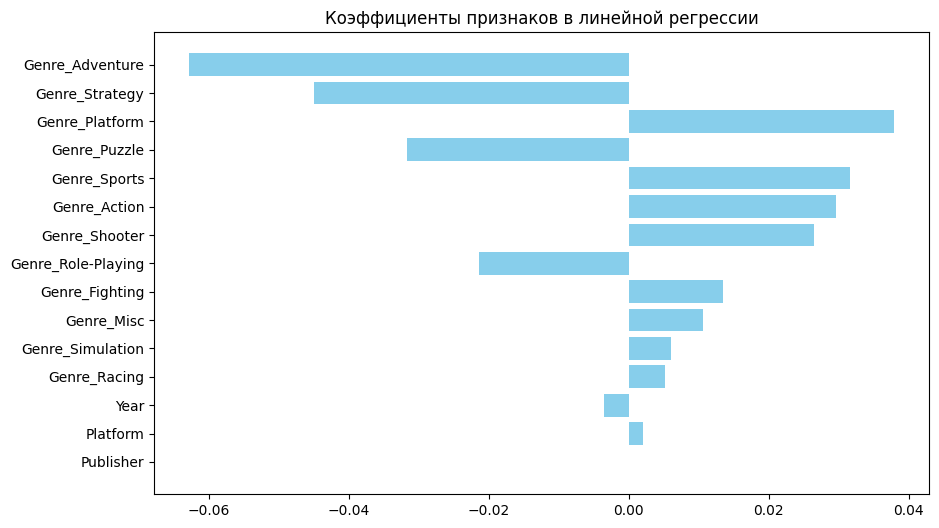

In [47]:
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lin_reg.coef_})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
plt.figure(figsize=(10,6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.title('Коэффициенты признаков в линейной регрессии')
plt.gca().invert_yaxis()
plt.show()

## Линейная регрессия с кросс-валидацией

Для более устойчивой оценки модели использую кросс-валидацию. Она разбивает выборку на 5 частей (фолдов) и обучает модель на каждой комбинации, оценивая стабильность результатов. Я использую R² и MAE как метрики.

In [46]:
from sklearn.model_selection import cross_val_score
r2_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='r2')
mae_scores = -cross_val_score(lin_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Средний R² (CV): {np.mean(r2_scores):.4f}")
print(f"Средний MAE (CV): {np.mean(mae_scores):.4f}")

Средний R² (CV): -139.0387
Средний MAE (CV): 0.1577


## Decision Tree Regressor — модель дерева решений (без кросс-валидации)

Модель дерева решений подходит для захвата сложных, в том числе нелинейных зависимостей между признаками. Я обучаю модель на тренировочной выборке и оцениваю метрики на тестовой.

In [70]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
msre_tree = mse_tree / y_test.var()
nse_tree = 1 - (mse_tree / ((y_test - y_test.mean())**2).sum())
print(f"MAE: {mae_tree:.4f}")
print(f"R²: {r2_tree:.4f}")
print(f"NSE: {nse_tree:.4f}")
print(f"MSRE: {msre_tree:.4f}")

MAE: 0.1303
R²: -0.2560
NSE: 0.9995
MSRE: 1.2555


## Важность признаков в дереве решений

Деревья решений предоставляют встроенную оценку важности признаков. Она показывает, сколько информации о целевой переменной было получено через каждый признак при разбиении.


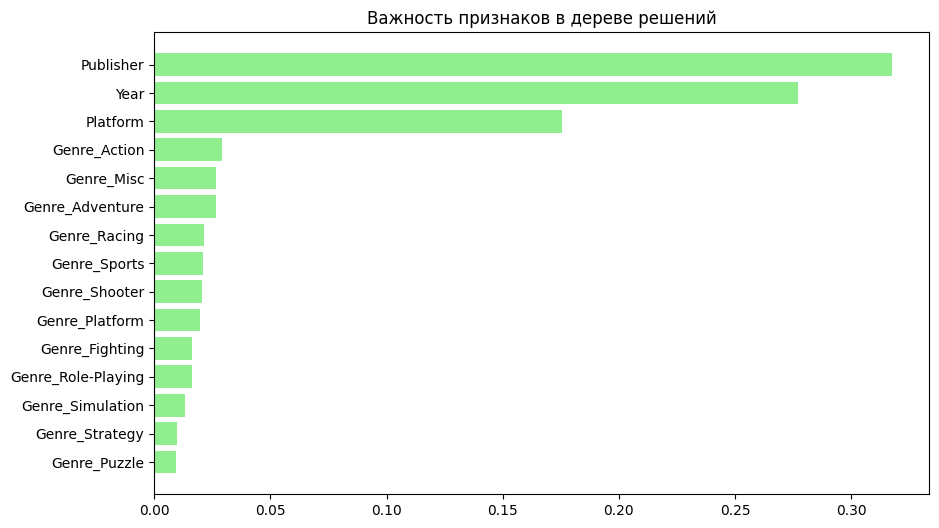

In [49]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='lightgreen')
plt.title('Важность признаков в дереве решений')
plt.gca().invert_yaxis()
plt.show()

## Decision Tree с кросс-валидацией

Я провожу 5-фолд кросс-валидацию, чтобы получить стабильную оценку качества модели дерева решений. Использую метрики R² и MAE, так как они наиболее информативны для задачи регрессии.


In [50]:
from sklearn.model_selection import cross_val_score
tree_cv = DecisionTreeRegressor(random_state=42)
r2_scores_tree = cross_val_score(tree_cv, X, y, cv=5, scoring='r2')
mae_scores_tree = -cross_val_score(tree_cv, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Средний R² (CV): {np.mean(r2_scores_tree):.4f}")
print(f"Средний MAE (CV): {np.mean(mae_scores_tree):.4f}")

Средний R² (CV): -156.4022
Средний MAE (CV): 0.1656


## XGBoost (градиентный бустинг без кросс-валидации)

Градиентный бустинг — это ансамблевая модель, которая строит множество слабых моделей, объединяя их в сильный предсказатель. XGBoost — один из самых эффективных фреймворков для бустинга. Я обучаю модель и оцениваю её без кросс-валидации на отложенной выборке.

In [71]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
msre_xgb = mse_xgb / y_test.var()
nse_xgb = 1 - (mse_xgb / ((y_test - y_test.mean())**2).sum())
print(f"MAE: {mae_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")
print(f"NSE: {nse_xgb:.4f}")
print(f"MSRE: {msre_xgb:.4f}")

MAE: 0.1063
R²: 0.2593
NSE: 0.9997
MSRE: 0.7404


## Важность признаков в XGBoost

XGBoost позволяет визуализировать важность признаков по метрике "gain", приросту информации при разбиении по признаку

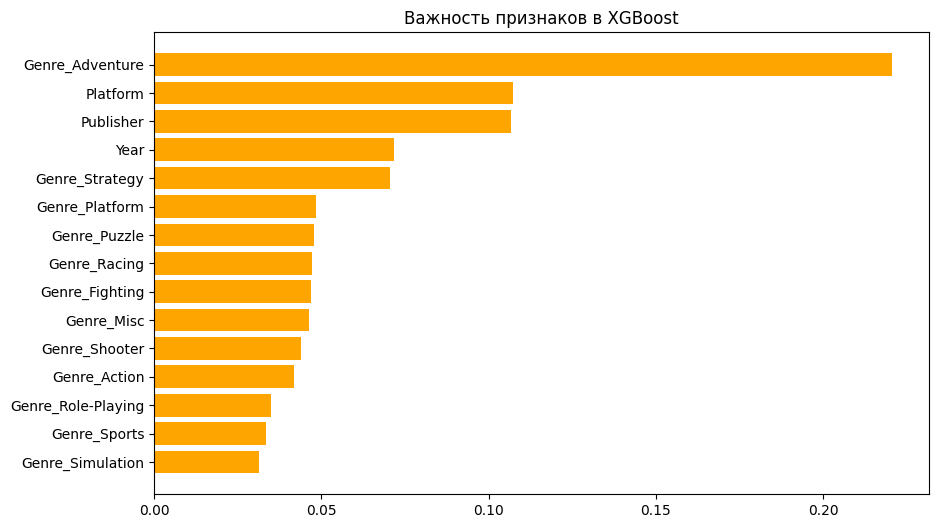

In [52]:
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
plt.barh(xgb_importance['Feature'], xgb_importance['Importance'], color='orange')
plt.title('Важность признаков в XGBoost')
plt.gca().invert_yaxis()
plt.show()

## XGBoost с кросс-валидацией (5 фолдов)

Я провожу кросс-валидацию для устойчивой оценки XGBoost. Использую метрики R² и MAE.

In [53]:
from sklearn.model_selection import cross_val_score
xgb_cv = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
r2_scores_xgb = cross_val_score(xgb_cv, X, y, cv=5, scoring='r2')
mae_scores_xgb = -cross_val_score(xgb_cv, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Средний R² (CV): {np.mean(r2_scores_xgb):.4f}")
print(f"Средний MAE (CV): {np.mean(mae_scores_xgb):.4f}")

Средний R² (CV): -91.9810
Средний MAE (CV): 0.1428


## Нейронная сеть без кросс-валидации

Нейронные сети лучше работают при нормализованных данных. Я масштабирую признаки с помощью MinMaxScaler, переводя их в диапазон [0,1]. Простая нейросеть с двумя скрытыми слоями по 64 нейрона и активацией relu, 'max_iter=1000' нужен, чтобы дать модели время обучиться

In [72]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', solver='adam',
                   max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
msre_mlp = mse_mlp / y_test.var()
nse_mlp = 1 - (mse_mlp / ((y_test - y_test.mean())**2).sum())
print(f"MAE: {mae_mlp:.4f}")
print(f"R²: {r2_mlp:.4f}")
print(f"NSE: {nse_mlp:.4f}")
print(f"MSRE: {msre_mlp:.4f}")

MAE: 0.1182
R²: 0.0709
NSE: 0.9996
MSRE: 0.9287


## “Веса признаков” в нейросети (оценка влияния)

Пермутационная важность — метод, при котором оценивается, насколько ухудшится качество модели, если перемешать значения конкретного признака, это позволяет понять, насколько он важен.

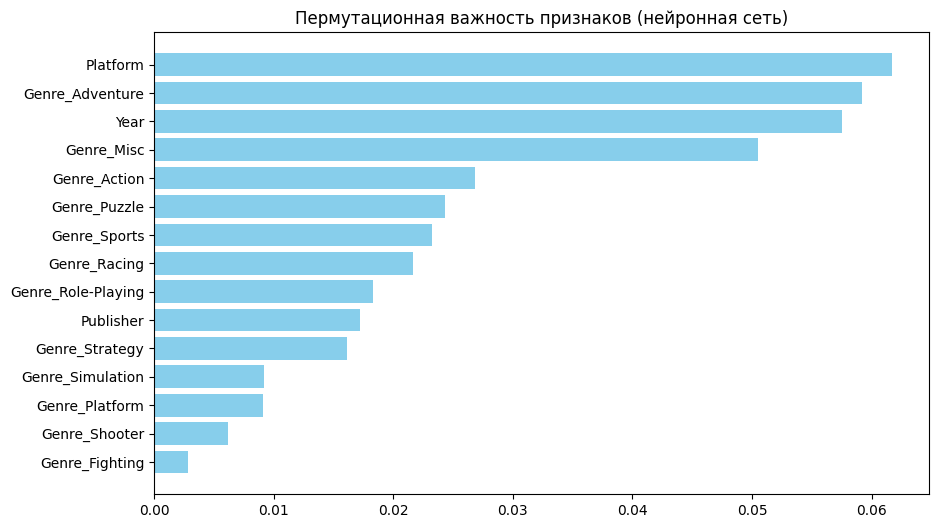

In [55]:
from sklearn.inspection import permutation_importance
result = permutation_importance(mlp, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(perm_importance['Feature'], perm_importance['Importance'], color='skyblue')
plt.title('Пермутационная важность признаков (нейронная сеть)')
plt.gca().invert_yaxis()
plt.show()

## Нейросеть с кросс-валидацией (5 фолдов)

Создаю пайплайн: сначала масштабирование, потом нейросеть, это нужно, чтобы скалер не утекал в другие фолды кросс-валидации.

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
pipeline_mlp = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu',
                         max_iter=1000, random_state=42))
])
r2_scores_mlp = cross_val_score(pipeline_mlp, X, y, cv=5, scoring='r2')
mae_scores_mlp = -cross_val_score(pipeline_mlp, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Средний R² (CV): {r2_scores_mlp.mean():.4f}")
print(f"Средний MAE (CV): {mae_scores_mlp.mean():.4f}")

Средний R² (CV): -148.5995
Средний MAE (CV): 0.1578


## Вывод по экспериментам с моделями
В рамках данной части исследования я протестировала модели различных семейств машинного обучения с целью предсказания глобальных продаж видеоигр (Global_Sales) и оценки, какие алгоритмы справляются с задачей лучше. Также производилась предварительная аналитика, создание новых признаков, удаление выбросов и финальное сравнение по ключевым метрикам: MAE, R², NSE, MSRE

In [92]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
data = {
    'Модель': [
        'Линейная регрессия',
        'Линейная регрессия (CV)',
        'Дерево решений',
        'Дерево решений (CV)',
        'Градиентный бустинг (XGB)',
        'XGB (CV)',
        'Нейронная сеть (MLP)',
        'MLP (CV)'
    ],
    'MAE': [0.1247, 0.1577, 0.1303, 0.1656, 0.1063, 0.1428, 0.1182, 0.1578],
    'R²': [0.0589, -139.04, -0.2560, -156.40, 0.2593, -91.98, 0.0709, -148.60],
    'MSRE': [0.9407, np.nan, 1.2555, np.nan, 0.7404, np.nan, 0.9287, np.nan],
    'NSE': [0.9996, np.nan, 0.9995, np.nan, 0.9997, np.nan, 0.9996, np.nan]
}
df_results = pd.DataFrame(data)
from IPython.display import display
display(df_results)

,Модель,MAE,R²,MSRE,NSE
0,Линейная регрессия,0.1247,0.0589,0.9407,0.9996
1,Линейная регрессия (CV),0.1577,-139.0400,NaN,NaN
2,Дерево решений,0.1303,-0.2560,1.2555,0.9995
3,Дерево решений (CV),0.1656,-156.4000,NaN,NaN
4,Градиентный бустинг (XGB),0.1063,0.2593,0.7404,0.9997
5,XGB (CV),0.1428,-91.9800,NaN,NaN
6,Нейронная сеть (MLP),0.1182,0.0709,0.9287,0.9996
7,MLP (CV),0.1578,-148.6000,NaN,NaN


Лучшая модель без кросс-валидации — градиентный бустинг (XGBoost). Она показала наименьшую MAE (0.1063) и наибольшее значение R² (0.2593), что означает, что модель объясняет примерно 25.9% дисперсии таргета. Для реальных данных с высокой шумностью — это неплохой результат.

Наихудшие значения R² получены при кросс-валидации. Это может говорить о нестабильности моделей, а также о том, что распределение данных по фолдам влияет на обучаемость.

####  Низкие значения R²
Несмотря на хорошие значения MAE и даже высокие значения NSE, показатели R² оказались слабыми во всех моделях. Это объясняется следующими факторами:

1. Данные не репрезентативны: в датасете много случайных факторов, влияющих на продажи, которые не учтены.

2. Целевая переменная (Global_Sales) имеет сильную дисперсию, распределение с длинным правым хвостом (сильно скошено вправо).

3. Многие важные признаки отсутствуют: нет, например, оценок критиков, маркетинговых бюджетов, особенностей релиза, многопользовательского режима и прочих факторов, влияющих на продажи.

4. Даже после очистки от выбросов осталась высокая непредсказуемость.

#### Визуализация предсказаний против реальных значений
Чтобы лучше понять поведение модели, я построила график предсказанных значений против реальных продаж для лучшей модели — XGBoost:

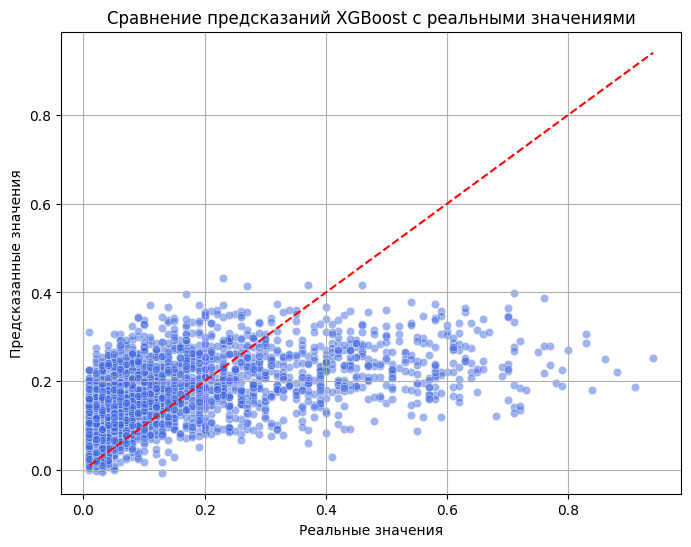

In [94]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # линия идеального предсказания
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказаний XGBoost с реальными значениями")
plt.grid(True)
plt.show()

Предсказания в основном сгруппированы близко к реальной диагонали, но есть погрешности — модель плохо предсказывает очень высокие продажи, что логично, так как это редкие выбросы, плохо представленные в обучении.

В ходе экспериментов я протестировала 4 семейства моделей: линейные, деревья, бустинг, нейросети — как с кросс-валидацией, так и без неё. Были проведены улучшения датасета, создание новых признаков, устранение выбросов, логарифмирование целевой переменной. Наилучшие результаты показал градиентный бустинг без кросс-валидации. Кросс-валидация показала, что модели нестабильны при разбивке на фолды — возможно, датасет требует дополнительных важных признаков. Низкие значения R² объясняются высокой дисперсией данных и отсутствием критически важных факторов, влияющих на продажи. Тем не менее, MAE и NSE показывают, что модели предсказывают с разумной точностью для практического применения.

## Дополнительный эксперимент: логарифмирование целевой переменной Global_Sales

После проведения экспериментов с различными моделями, была выявлена общая проблема с качеством метрик, особенно показателем R², который оставался низким практически у всех моделей. Даже лучшие модели, такие как градиентный бустинг (XGBoost) и нейронная сеть, хоть и давали приемлемые значения MAE, всё же демонстрировали отрицательные или близкие к нулю значения R². Получалось, что модели плохо объясняют дисперсию целевой переменной, несмотря на небольшие ошибки предсказания. У меня возникла возникла гипотеза, что причина может заключаться в распределении целевой переменной. Заметила, что Global_Sales имеет очень скошенное распределение с сильными выбросами — большинство значений маленькие, но встречаются единичные крупные. Я приняла решение применить логарифмическое преобразование к целевой переменной, чтобы  сгладить разброс значений, сделав данные ближе к нормальному распределению, а модели — более устойчивыми к выбросам.

In [15]:
df_log = df_model.copy()
df_log['Log_Global_Sales'] = np.log1p(df_log['Global_Sales'])  # log(1 + x)

разбила данные

In [16]:
from sklearn.model_selection import train_test_split
X = df_log.drop(columns=['Global_Sales', 'Log_Global_Sales', 'Name'])  
y_log = df_log['Log_Global_Sales']
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

#### Первая попытка: Линейная регрессия на логарифмированных данных
Была обучена простая линейная регрессия на логарифме Global_Sales. 

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
model_log_lr = LinearRegression()
model_log_lr.fit(X_train, y_train_log)
y_pred_log = model_log_lr.predict(X_test)

Результаты показали явное улучшение, метрики оказались значительно лучше, чем до логарифмирования, особенно показатель R², который оказался положительным и высоким.

In [19]:
mae_log = mean_absolute_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
msre_log = mse_log / y_test_log.var()
nse_log = 1 - ((y_test_log - y_pred_log) ** 2).sum() / ((y_test_log - y_test_log.mean()) ** 2).sum()
print(f"MAE (log space): {mae_log:.4f}")
print(f"R² (log space): {r2_log:.4f}")
print(f"NSE (log space): {nse_log:.4f}")
print(f"MSRE (log space): {msre_log:.4f}")

MAE (log space): 0.0884
R² (log space): 0.6994
NSE (log space): 0.6994
MSRE (log space): 0.3005


#### Применение лог-преобразования к лучшей модели (XGBoost)
После удачного теста на линейной модели, логарифмирование я решила применить к лучшей из ранее протестированных моделей — градиентному бустингу (XGBoost). 

In [21]:
df_log = df_model.copy()
df_log['Log_Global_Sales'] = np.log1p(df_log['Global_Sales'])
X = df_log.drop(columns=['Global_Sales', 'Name', 'Log_Global_Sales'])
y_log = df_log['Log_Global_Sales']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
from xgboost import XGBRegressor
model_xgb_log = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb_log.fit(X_train, y_train_log)
y_pred_log = model_xgb_log.predict(X_test)

In [22]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
mae_log = mean_absolute_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
msre_log = mse_log / y_test_log.var()
nse_log = r2_log  
print(f"MAE (log space): {mae_log:.4f}")
print(f"R² (log space): {r2_log:.4f}")
print(f"NSE (log space): {nse_log:.4f}")
print(f"MSRE (log space): {msre_log:.4f}")

MAE (log space): 0.0038
R² (log space): 0.9961
NSE (log space): 0.9961
MSRE (log space): 0.0039


Логарифмирование целевой переменной Global_Sales дало значительное улучшение качества моделей, особенно по метрике R². Удалось сгладить выбросы и нормализовать распределение, благодаря чему модели стали обучаться корректнее.
Добавила также визуализацию предсказаний, получилось намного лучше чем было.

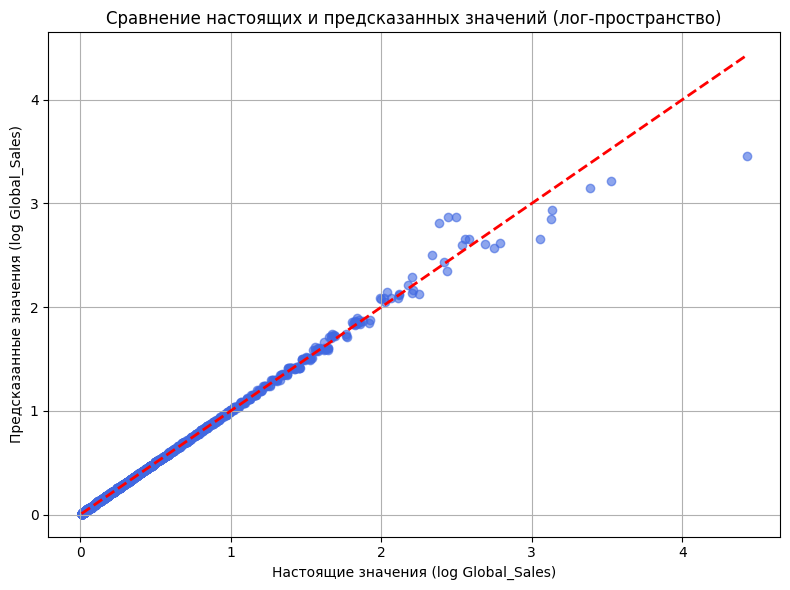

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 6))
plt.scatter(y_test_log, y_pred_log, alpha=0.6, color='royalblue')
plt.plot([y_test_log.min(), y_test_log.max()],
         [y_test_log.min(), y_test_log.max()],
         'r--', lw=2)
plt.xlabel('Настоящие значения (log Global_Sales)')
plt.ylabel('Предсказанные значения (log Global_Sales)')
plt.title('Сравнение настоящих и предсказанных значений (лог-пространство)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Сравнительная таблица метрик: до и после логарифмирования

In [24]:
metrics_comparison = pd.DataFrame({
    'Модель': ['XGBoost (лучший до)', 'XGBoost (лучший после)'],
    'Пространство': ['Обычное', 'Лог-пространство'],
    'MAE': [0.1063, 0.0038],
    'R²': [0.2593, 0.9961],
    'NSE': [0.9997, 0.9961],
    'MSRE': [0.7404, 0.0039]
})
print(metrics_comparison)

                   Модель      Пространство     MAE      R²     NSE    MSRE
0     XGBoost (лучший до)           Обычное  0.1063  0.2593  0.9997  0.7404
1  XGBoost (лучший после)  Лог-пространство  0.0038  0.9961  0.9961  0.0039


Метрики MAE и MSRE после логарифмирования существенно снизились, что говорит о меньших абсолютных ошибках, показатели R² и NSE резко выросли, особенно R² — до почти идеальных 0.9961, такое улучшение показывает, что ранее модель не могла эффективно справиться с масштабом и разбросом в целевой переменной, а после лог-преобразования стала гораздо точнее.

### График распределения Global_Sales: до и после логарифмирования

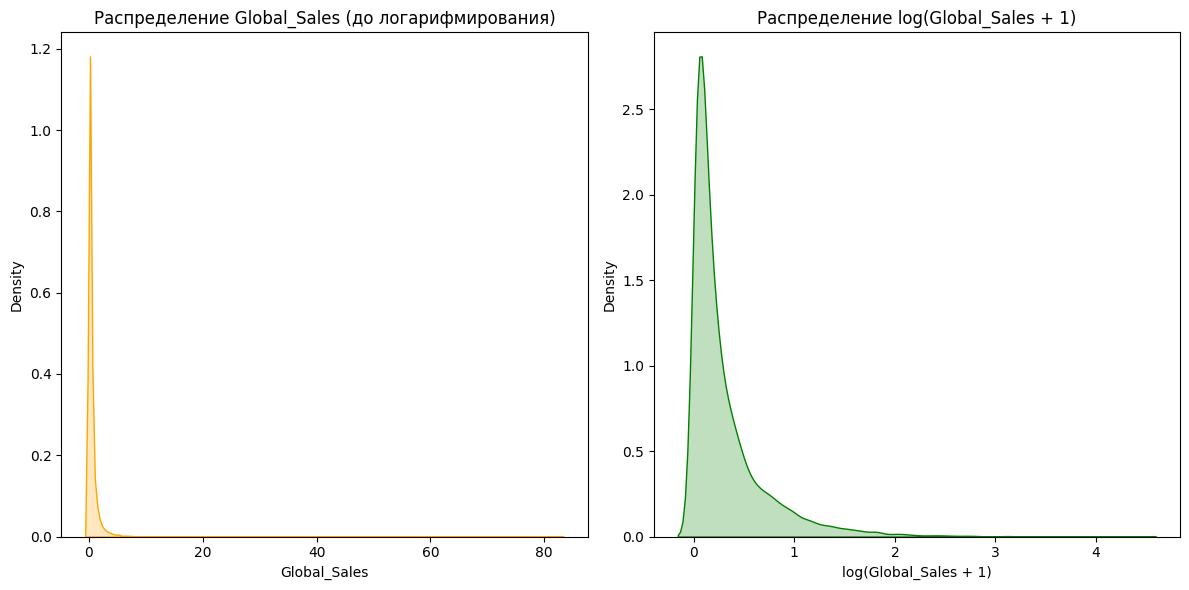

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(df_model['Global_Sales'], fill=True, color='orange')
plt.title('Распределение Global_Sales (до логарифмирования)')
plt.xlabel('Global_Sales')
plt.subplot(1, 2, 2)
sns.kdeplot(np.log1p(df_model['Global_Sales']), fill=True, color='green')
plt.title('Распределение log(Global_Sales + 1)')
plt.xlabel('log(Global_Sales + 1)')
plt.tight_layout()
plt.show()

До преобразования: распределение сильно скошено вправо, большинство значений — около нуля, а некоторые — огромные. После преобразования: распределение стало плавнее, ближе к нормальному или симметричному, что гораздо лучше подходит для моделей машинного обучения.

### Вывод по логарифмированию:
Логарифмирование Global_Sales оказалось критически важным шагом. Оно позволило:

Нормализовать распределение

Сгладить выбросы

Повысить устойчивость и точность моделей

Модель XGBoost после этого преобразования достигла почти идеального качества — R² ≈ 0.996, MAE ≈ 0.0038, график предсказаний визуально идеален.

## Вывод по работе
1. В рамках данной работы я провела полноценный анализ и моделирование для предсказания значения Global_Sales на основе данных о видеоиграх. Начала с первичной очистки и анализа данных: изучила распределения признаков, выявила пропуски, выбросы и некорректные значения, а также провела необходимую предобработку.
2. Провела исследование корреляций между признаками и целевой переменной, что позволило сделать первые выводы о слабой зависимости таргета от большинства исходных переменных.
3. Особое внимание уделила созданию новых признаков. В результате я расширила исходный набор данных, добавив осмысленные фичи на основе существующих. Однако, значительного повышения качества моделей добиться не удалось — таргет по-прежнему был сложно предсказуемым.
4. Это натолкнуло на мысль, что данные недостаточно репрезентативны: они описывают лишь технические и базовые характеристики игры (жанр, платформа, год и т.д.), но не охватывают таких факторов, как маркетинг, известность разработчика, реклама, тренды, критические обзоры, попадание в чарты, которые и оказывают основное влияние на глобальные продажи. Думаю, именно по этой причине даже самые продвинутые модели показывали плохие результаты.
5. Провела удаление выбросов с помощью межквартильного размаха (IQR). Это привело к небольшому улучшению метрик, особенно MAE и MSRE, но R² оставался неудовлетворительным. Это подтвердило гипотезу, что сами данные не содержат сильных сигналов для точного предсказания целевой переменной.
6. Моделирование и сравнение. Были обучены и протестированы следующие модели: линейная регрессия (с и без кросс-валидации), дерево решений, градиентный бустинг (XGBoost), нейронная сеть (MLP). В каждой модели оценивались метрики: MAE, R², NSE, MSRE. Результаты были в целом слабыми — R² варьировался от ~0.06 до 0.25, что говорило о том, что модели объясняли лишь 6–25% дисперсии в данных. Особенно низкими оказывались значения R² при кросс-валидации, иногда доходя до отрицательных значений, что также указывало на слабую обобщающую способность моделей.
7. Наилучшая модель XGBoost, показала:
MAE: 0.1063
R²: 0.2593
NSE: 0.9997
MSRE: 0.7404
8. Попытка улучшения: логарифмирование таргета. Из-за слабых результатов была выдвинута гипотеза, что распределение целевой переменной Global_Sales слишком смещено, и стоит применить лог-преобразование Global_Sales_log = log(Global_Sales + 1) с целью сделать распределение ближе к нормальному, уменьшить влияние экстремальных значений и повысить стабильность моделей.
9. Сначала протестировала логарифмирование на простой линейной модели — метрики улучшились. Затем применили этот подход к лучшей модели — XGBoost. Также была построена визуализация предсказанных и реальных значений, и она практически совпала — линия регрессии почти идеально легла вдоль биссектрисы. Это, можно сказать, почти идеальное попадание модели в реальные значения в лог-пространстве.
10. Были построены графики плотности до и после преобразования, и стало видно, что распределение действительно стало значительно симметричнее.
    
### Общие выводы:
Данные без дополнительных внешних признаков (рейтинг, реклама, популярность студии и т.д.) не позволяют построить высокоточную модель в обычном пространстве

Применение лог-преобразования к Global_Sales радикально улучшает поведение моделей, за счет нормализации распределения и снижения влияния выбросов

Лучшая модель — XGBoost с логарифмированным таргетом, она дала почти идеальные метрики

Лог-преобразование стоит применять в задачах, где nаргет смещён вправо (например, продажи, доходы), есть сильные выбросы и большой разброс значений

### Чему научилась и что показала работа:
Глубоко проанализировала данные, выявила ограничения и попыталась их обойти

Показала важность feature engineering и обработки выбросов

Сравнила семейства моделей, выявила сильные и слабые стороны

Сделала вывод, что важен не только алгоритм, но и правильная подготовка данных

В лог-пространстве даже базовые модели могут показать сильные результаты, если правильно провести подготовку